In [1]:
def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

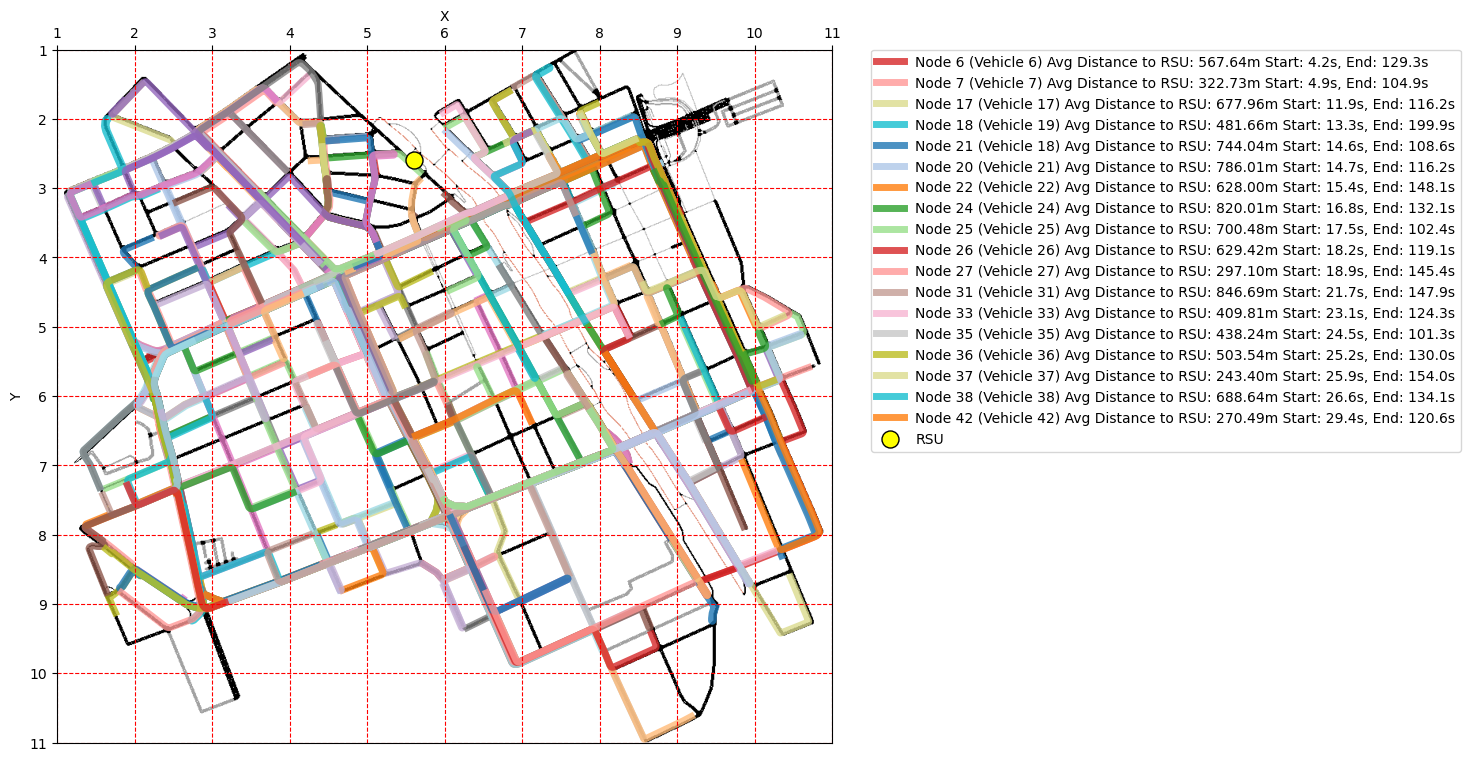

: 

In [ ]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.cm as cm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import xml.etree.ElementTree as ET # type: ignore
from collections import defaultdict # type: ignore
import matplotlib.patheffects as path_effects # type: ignore
from matplotlib.ticker import FixedFormatter, FixedLocator # type: ignore

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width = 1300, map_height = 1600, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df

def calculate_average_distance_to_rsu(data, rsu_x, rsu_y):
    distances = []
    for _, row in data.iterrows():
        distance = np.sqrt((row['x'] - rsu_x)**2 + (row['y'] - rsu_y)**2)
        distances.append(distance)
    return np.mean(distances)

    #plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
def plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height, grid_size=10, rsu_x=560, rsu_y=1160):
    grid_avg_metric = calculate_grid_metric(data, grid_size, map_width, map_height)

    plt.figure(figsize=(10, 9))
    bg_img = mpimg.imread('resource/background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)
    unique_vehicle_ids = data['vehicle_id'].unique()

    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    for vehicle_id in unique_vehicle_ids:
        vehicle_data = data[data['vehicle_id'] == vehicle_id]
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]

        start_time = vehicle_data['time'].min()
        end_time = vehicle_data['time'].max()

        avg_distance_to_rsu = calculate_average_distance_to_rsu(vehicle_data, rsu_x, rsu_y)

        
        
        if start_time < 30 and end_time >= 100:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                label=f'Node {node_id} (Vehicle {vehicle_id}) Avg Distance to RSU: {avg_distance_to_rsu:.2f}m Start: {start_time:.1f}s, End: {end_time:.1f}s', 
                zorder=1
            )
        else:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                zorder=1
            )

    plt.xlabel("X")
    plt.ylabel("Y")

    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()

def calculate_grid_metric(data, grid_size, map_width, map_height):
    grid_metric = defaultdict(list)
    for _, row in data.iterrows():
        grid_x = row['grid_x']
        grid_y = row['grid_y']

        grid_metric[(grid_x, grid_y)].append(row['vehicle_id'])

    grid_avg_metric = {}
    for (grid_x, grid_y), vehicle_counts in grid_metric.items():
        avg_vehicles = len(vehicle_counts) / len(data['time'].unique())
        grid_avg_metric[(grid_x, grid_y)] = avg_vehicles

    return grid_avg_metric

def main():
    node_table = load_node_table('resource/node_table_low.txt')

    target_node_ids = [i for i in range(0, 231)]
    # 4 6 7 8 10 11 14 17 18 
    # 19 20 21 22 24 25 26
    # 19 21 
    #target_node_ids = [22, 24, 25]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]

    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}

    dx, dy = 230, 330
    map_width=1540
    map_height=1380
    data = extract_data_from_xml('resource/map0.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)
    plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height)

if __name__ == "__main__":
    main()

In [2]:
def remove_duplicates_from_file(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    seen = set()
    unique_lines = []
    
    for line in lines:
        if line not in seen:
            unique_lines.append(line)
            seen.add(line)
    
    with open(output_file, 'w') as file:
        file.writelines(unique_lines)

input_file = 'resource/external_id_table_middle.txt'
output_file = 'resource/node_table_middle.txt'

remove_duplicates_from_file(input_file, output_file)